In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
random.seed(5)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Transformer Model Class

In [2]:
class SelfAttention(nn.Module):
    """
    Implements multi-head self-attention mechanism.
    Splits input embeddings into multiple heads, computes attention scores,
    and applies them to the value vectors.
    """
    def __init__(self, 
                 embed_size, 
                 heads,
                 dropout = 0.1):
        super(SelfAttention, self).__init__()

        self.embed_size= embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert (embed_size / heads  == self.head_dim ), "The ratio embed_size / heads should be an integer"

        self.values =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.keys =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.queries =nn.Linear(self.embed_size, self.embed_size, bias = False )
        self.fc_out =nn.Linear(self.embed_size, self.embed_size ) #
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, queries, mask = None):
        N = queries.shape[0]

        value_len, key_len, query_len =  values.shape[1], keys.shape[1] , queries.shape[1]

        # Separate K,V, Q by passing them to a linear layer --> keep the weights matrixes indipendents 
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Separates value, keys and queries embedding into heads with equal size
        values = values.reshape(N, value_len, self.heads, self.head_dim )   # (N, value_len, heads, head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim )         # (N, key_len, heads, head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim ) # (N, query_len, heads, head_dim)

        # 1- Multiply queries with keys
        # queries shape: (N, query_len,  self.heads, self.head_dim ) (nqhd)
        # keys shape: (N, key_len,  self.heads, self.head_dim )  (nkhd)
        # queries_by_keys: (N, self.heads, query_len, key_len) (nhqk)
        queries_by_keys = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            queries_by_keys= queries_by_keys.masked_fill(mask==0, float("-1e10"))  #-1e10
            # print(queries_by_keys)

        attention = torch.softmax(queries_by_keys / (self.embed_size ** (1/2)), dim = -1) # softmax across keys
        attention = self.dropout(attention)
        
        # 2- Multiply attention with values
        # attention: (N, self.heads, query_len, key_len) (nhql)
        # values shape: (N, value_len,  self.heads, self.head_dim )  (nlhd)
        # attention_by_values: (N, query_len,  self.heads, self.head_dim )  (nqhd)
        attention_by_values =  torch.einsum("nhql,nlhd->nqhd", [attention, values]).\
            reshape(N, query_len, self.embed_size )  # (N, query_len,  self.embed_size)

        out = self.fc_out(attention_by_values) # (N, query_len,  self.embed_size) -> (N, query_len, self.embed_size)
        return(out)
    
class TransformerBlock(nn.Module):
    """
    A single transformer block consisting of a self-attention layer and a feed-forward network,
    each followed by layer normalization and residual connections.
    """
    def __init__(self, 
                 embed_size, 
                 heads, 
                 dropout, 
                 expansion):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, expansion * embed_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(expansion * embed_size, embed_size))

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention)) + query 
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward )) +  x  
        return out


class Encoder(nn.Module):
    """
    The encoder consists of an embedding layer, positional encoding, and multiple TransformerBlocks.
    """
    def __init__(self, 
                 source_vocab_size, 
                 embed_size, 
                 num_layers,
                 heads,
                 device,
                 expansion,
                 dropout,
                 max_sentence_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(source_vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_sentence_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, 
                                heads, 
                                dropout, 
                                expansion) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)#.to(device)

    def forward(self, x, mask):
        #print('Encoder forward')
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N,seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.pos_embedding(positions)) 
        )

        # loop over each TransformerBlock
        for layer in self.layers:
            out = layer(out, out, out, mask)
        return out 

class DecoderBlock(nn.Module):
    """
    A single decoder block containing masked self-attention, encoder-decoder attention, and feed-forward network.
    """
    def __init__(self, 
                embed_size, 
                heads,
                expansion,
                dropout,
                device):
        super(DecoderBlock, self).__init__() 
        # self.device = device
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.tranformer_block = TransformerBlock(embed_size, 
                                                heads, 
                                                dropout, 
                                                expansion)
                                                
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, query, source_mark, target_mask):
        attention = self.attention(x, x, x, target_mask)
        query = self.dropout(self.norm(attention )) +x     #####
        out = self.tranformer_block(value, key, query, source_mark)
        return out
    

class Decoder(nn.Module):
    """
    The decoder consists of an embedding layer, positional encoding, multiple DecoderBlocks,
    and a final linear layer to map embeddings to vocabulary size.
    """
    def __init__(self, 
                 target_vocab_size, 
                 embed_size, 
                 num_layers,
                 heads,
                 device,
                 expansion,
                 dropout,
                 max_sentence_length):
        super(Decoder, self).__init__() 
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(target_vocab_size, embed_size)
        self.pos_embedding = nn.Embedding(max_sentence_length, embed_size)
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_size, 
                                heads, 
                                expansion,
                                dropout, 
                                device) for _ in range(num_layers)]
        )
        self.fc_out = nn.Linear(embed_size, target_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x , enc_out, source_mask, target_mask):
        #print('decoder forward')
        N, seq_length = x.shape

        positions = torch.arange(0, seq_length).expand(N,seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.pos_embedding(positions)) 

        # loop over each DecoderBlocks
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, enc_out,  source_mask, target_mask )

        # (N, max_sentence_length, embedding_size) --> (N, max_sentence_length, target_vocab_size)
        out = self.fc_out(x) 
        return out

class Transformer(nn.Module):
    """
    Implements the full Transformer model consisting of an Encoder and Decoder,
    responsible for sequence-to-sequence learning tasks like translation.
    """
    def __init__(self, 
            target_vocab_size, 
            source_vocab_size,
            target_pad_index,
            source_pad_index,
            embed_size, 
            num_layers,
            heads,
            device,
            expansion,
            dropout,
            max_sentence_length,
            debug = False):
        
        super(Transformer, self).__init__()

        self.embed_size = embed_size
        self.device = device
        self.source_pad_index = source_pad_index
        self.target_pad_index = target_pad_index
        self.debug  = debug

        self.encoder = Encoder(source_vocab_size, 
                                embed_size, 
                                num_layers,
                                heads,
                                device,
                                expansion,
                                dropout,
                                max_sentence_length)#.to(device)
        
        self.decoder = Decoder(target_vocab_size, 
                                embed_size, 
                                num_layers,
                                heads,
                                device,
                                expansion,
                                dropout,
                                max_sentence_length)#.to(device)

        self.linear_out = nn.Linear(embed_size, target_vocab_size)#.to(device)
        

    def make_source_mask(self, source):

        # source_mask shape : (N, 1, 1, source_length)
        source_mask = (source != self.source_pad_index).unsqueeze(1).unsqueeze(2)  

        #print( 'source_mask\n' , source_mask)
        return source_mask.to(self.device)
    
    def make_target_mask(self, target):
        N, target_len = target.shape
        # target mask : (1, 1 seq_len) &  (N, 1, seq_length, seq_length )
        target_mask = \
            ((target != self.target_pad_index).unsqueeze(1).int().to(self.device) & \
             torch.tril(torch.ones((N, target_len, target_len)), diagonal=0).int().to(self.device)).unsqueeze(1)  

        return target_mask.to(self.device)

    def forward(self, source, target):
        source_mask = self.make_source_mask(source)
        target_mask = self.make_target_mask(target)

        enc_src = self.encoder(source, source_mask)
        out = self.decoder(target, enc_src, source_mask, target_mask)
        if self.debug:
            print('----------------------------')
            print('source_mask:\n' , source_mask, source_mask.shape, '\n ---------------------------------------')
            print('target_mask:\n' , target_mask,  target_mask.shape,'\n---------------------------------------')
            print('source:\n' , source,      source.shape,     '\n---------------------------------------')
            print('target:\n' , target,    target.shape,       '\n---------------------------------------')
        return out

### Test the transformer model 

In [3]:
# instantiate the model 
target_vocab_size = 10
source_vocab_size = 10 
embed_size = 2
heads = 1
max_sentence_length = 9

# func to count the number of params:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters())
    if params >1_000_000:
        params = int(params/1_000_000)
        print('Model parameters (millions):', params)
    else:
        params = round(params/1_000, 3)
        print('Model parameters (thousands):', params)

    return params

test_model  = Transformer(target_vocab_size = target_vocab_size, 
                source_vocab_size = source_vocab_size ,
                target_pad_index =0,
                source_pad_index =0,
                embed_size = embed_size, 
                num_layers = 1,
                heads =  heads,
                device = 'cuda',
                expansion = 2,
                dropout =0.2,
                max_sentence_length = max_sentence_length,
                debug = False)

test_model = test_model.to('cuda')

_ = count_parameters(test_model)

Model parameters (thousands): 0.254


In [4]:
# Generate source_test data
source_test = torch.tensor([[5, 3, 4, 2, 7, 8, 5, 8, 9],
        [9, 5, 3, 8, 7, 6, 6, 0, 0],
        [8,  4, 2, 6, 5, 3, 9, 6, 0]], device= 'cuda')

# Generate target_test data
target_test = torch.tensor([[4,  6, 1, 0, 0, 0, 0, 0, 0],
        [6, 2,  2, 9, 6, 3, 4, 0, 0],
        [9, 6,  6, 9, 9, 2, 7, 0, 0]], device= 'cuda')


print( 'source_test shape:' , source_test.shape)
print( 'target_test shape:' , target_test.shape)

source_test shape: torch.Size([3, 9])
target_test shape: torch.Size([3, 9])


In [5]:
# Make the prediction on the test data and confirm the output shape is correct
result = test_model(source_test,target_test)

print('shape of output tensor:',result.shape)
result[:,:5,:5]

shape of output tensor: torch.Size([3, 9, 10])


tensor([[[-0.5393, -1.0106, -1.7074, -0.9833, -0.6753],
         [ 2.1594,  0.3880,  1.4797, -0.3792,  0.1188],
         [ 0.1612, -1.5776, -2.8885, -2.7095, -1.5224],
         [ 0.2395,  0.2442,  1.0504,  0.9142,  0.5177],
         [ 0.6339, -1.1732, -1.9858, -2.2807, -1.2027]],

        [[-0.7360, -1.4795, -2.7322, -1.7704, -1.1488],
         [-0.4599, -0.9666, -1.6076, -0.9599, -0.6488],
         [ 1.0255, -0.6927, -0.9241, -1.6312, -0.7732],
         [-0.9830, -1.5188, -2.8324, -1.6461, -1.1211],
         [-0.4458, -0.8381, -1.3292, -0.7113, -0.5074]],

        [[ 0.8394, -0.2546,  0.0105, -0.5906, -0.2226],
         [ 1.5075,  0.5894,  1.8743,  0.5667,  0.5376],
         [ 1.2744, -0.0601,  0.4573, -0.5559, -0.1297],
         [-0.9848, -1.5205, -2.8361, -1.6480, -1.1225],
         [-0.8752, -1.8234, -3.4833, -2.3516, -1.4975]]], device='cuda:0',
       grad_fn=<SliceBackward0>)

# Dataset Class

### Check the data

In [6]:
# Load the data
data = load_dataset('opus_books', 'en-it', split = 'train')
data

Dataset({
    features: ['id', 'translation'],
    num_rows: 32332
})

In [7]:
# Check a random translation pair
data[5]['translation']

{'en': 'We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.',
 'it': "La mattina avevamo errato per un'ora nel boschetto spogliato di foglie, ma dopo pranzo (quando non vi erano invitati, la signora Reed desinava presto), il vento gelato d'inverno aveva portato seco nubi così scure e una pioggia così penetrante, che non si poteva pensare a nessuna escursione."}

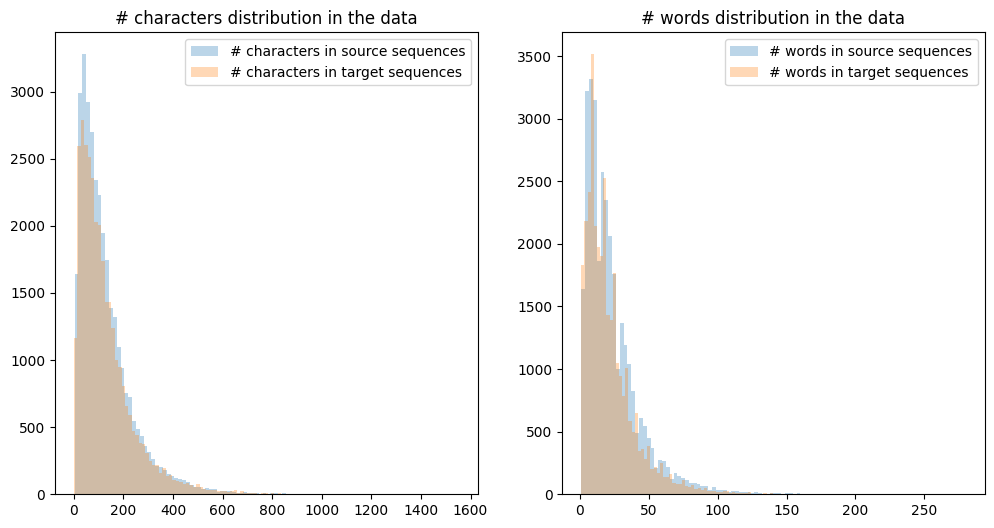

In [8]:
# distribution of character and words numbers --> to identify an efficient min and max number of characters / words
length_sources_char, length_target_char, length_sources_words, length_target_words = [] ,[],[],[]
for i in data:
    length_sources_char.append(len(i['translation']['en']))
    length_target_char.append(len(i['translation']['it']))

    length_sources_words.append(len(i['translation']['en'].split(' ')))
    length_target_words.append(len(i['translation']['it'].split(' ')))

plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.title('# characters distribution in the data')
plt.hist(length_sources_char, bins = 100,alpha = 0.3, label= '# characters in source sequences')
plt.hist(length_target_char, bins = 100, alpha = 0.3, label= '# characters in target sequences')
plt.legend()
plt.subplot(1,2,2)
plt.title('# words distribution in the data')
plt.hist(length_sources_words, bins = 100,alpha = 0.3, label= '# words in source sequences')
plt.hist(length_target_words, bins = 100, alpha = 0.3, label= '# words in target sequences')

plt.legend()
plt.show()

In [9]:
# Filter data function
def filter_data(data, min_number, max_number, lang1, lang2, method = 'characters'):
    """
    Filters a dataset of translations based on length constraints.

    Parameters:
    - data (list): A list of dictionaries containing translations in different languages.
                   Each dictionary follows the structure:
                   {'translation': {lang1: 'text in lang1', lang2: 'text in lang2'}}
    - min_number (int): The minimum length a translation must have to be included.
    - max_number (int): The maximum length a translation can have to be included.
    - lang1 (str): The key representing the first language in the translation pair.
    - lang2 (str): The key representing the second language in the translation pair.
    - method (str, optional): The method to measure translation length. 
                              Options: 'characters' (default) or 'words'.
    """
    assert method in ['characters', 'words']
    out = []
    n_rows_start = len(data)
    for d in data:
        if method == 'characters':
            l1 = len(d['translation'][lang1])
            l2 = len(d['translation'][lang2])
            if l1>min_number and l2>min_number and l1 < max_number and  l2<max_number:
                out.append({'translation':{lang1:d['translation'][lang1],  lang2:d['translation'][lang2]}})

        elif method == 'words':
            l1 = len(d['translation'][lang1].split(' '))
            l2 = len(d['translation'][lang2].split(' '))

            if l1>min_number and l2>min_number and l1 < max_number and  l2<max_number:
                out.append({'translation':{lang1:d['translation'][lang1],  lang2:d['translation'][lang2]}})

            
    
    n_rows_end = len(out)
    print(f"Started with {n_rows_start} rows. {n_rows_end} rows are left")

    return out

In [10]:
data_filtered = filter_data(data, min_number = 50, max_number= 500, lang1 = 'en', lang2 ='it', method = 'characters')

Started with 32332 rows. 22531 rows are left


In [11]:
# function to build the tokenizer
def build_tokenizer(all_sentences , tokenizer_path_out = None):
    tokenizer = Tokenizer(WordLevel(unk_token= "[UNK]")) # 
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2)
    tokenizer.train_from_iterator(all_sentences, trainer=trainer)
    return tokenizer

# function to retrieve data 
def retrieve_data(lang1  , lang2 , filter_range, method ):
    lang1_data, lang2_data = [], []
    # load data
    data = load_dataset('opus_books', f'{lang1}-{lang2}', split = 'train')

    # filter the data remove too short and too long sentences
    if filter_range != None:
        data = filter_data(data, min_number = filter_range[0], max_number= filter_range[1], lang1 = 'en', lang2 ='it', method = method)
    for row in data:
        lang1_data.append(row['translation'][lang1])
        lang2_data.append(row['translation'][lang2])
    
    return lang1_data, lang2_data

# function to retrieve data and fit tokenizer
def create_tokenizer_and_corpus_train_test(lang1 , lang2 , train_split = 0.9, filter_range = None, method = 'words'):
    """
    Return dict:
        - trained tokenizer on source text (lang1)
        - trained tokenizer on target text (lang2)
        - source text corpus (train, validation)
        - target text corpus (train, validation)
    """
    # retrice the two corpuses 
    source_text_corpus, target_text_corpus =  retrieve_data(lang1 = lang1 , lang2= lang2 , filter_range = filter_range, method = method)

    # fit tokenizers
    source_tokenizer = build_tokenizer(all_sentences = source_text_corpus)
    target_tokenizer = build_tokenizer(all_sentences = target_text_corpus)

    # Crate train / val split 
    train_val_split = int(len(source_text_corpus) * train_split )

    # Shuffle the data
    indexes = list(range(len(source_text_corpus)))                        
    random.shuffle(indexes)                                                
    source_text_corpus = [source_text_corpus[i] for i in indexes]         
    target_text_corpus = [target_text_corpus[i] for i in indexes]         

    source_text_corpus_train = source_text_corpus[:train_val_split]
    source_text_corpus_val = source_text_corpus[train_val_split:]

    target_text_corpus_train = target_text_corpus[:train_val_split]
    target_text_corpus_val = target_text_corpus[train_val_split:]
    
    data = {"source_tokenizer":source_tokenizer, 
            "target_tokenizer": target_tokenizer , 
            "source_train_set":source_text_corpus_train, 
            "source_val_set":  source_text_corpus_val,
            "target_train_set" :  target_text_corpus_train,
            "target_val_set": target_text_corpus_val}

    return data


tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', lang2 = 'it', train_split= 0.9)

In [12]:
# class to contain the data
class TranslationDataset(Dataset):
    """ 
    This class tokenizes and processes source and target language sentences, 
    ensuring they fit within specified sequence lengths and include special 
    tokens such as [SOS] (start of sequence), [EOS] (end of sequence), and [PAD] (padding).

    Attributes:
        source_tokenizer (Tokenizer): Tokenizer for the source language.
        target_tokenizer (Tokenizer): Tokenizer for the target language.
        source_corpus (list of str): List of source language sentences.
        target_corpus (list of str): List of target language sentences.
        source_seq_length (int): Maximum sequence length for the source language.
        target_seq_length (int): Maximum sequence length for the target language.
        sos_token (torch.Tensor): Tensor representing the start-of-sequence token.
        eos_token (torch.Tensor): Tensor representing the end-of-sequence token.
        pad_token (torch.Tensor): Tensor representing the padding token.

    """
    def __init__(self, 
                 source_tokenizer, 
                 target_tokenizer,  
                 source_corpus, 
                 target_corpus, 
                 source_seq_length, 
                 target_seq_length):
        super().__init__()

        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_corpus = source_corpus
        self.target_corpus = target_corpus
        self.source_seq_length = source_seq_length
        self.target_seq_length = target_seq_length

        self.sos_token = torch.tensor([source_tokenizer.token_to_id('[SOS]')], dtype= torch.int64)
        self.eos_token = torch.tensor([source_tokenizer.token_to_id('[EOS]')], dtype= torch.int64)
        self.pad_token = torch.tensor([source_tokenizer.token_to_id('[PAD]')], dtype= torch.int64)

    def __len__(self):
        return len(self.source_corpus)
    
    def __getitem__(self, index):
        source_text = self.source_corpus[index]
        target_text = self.target_corpus[index]

        enc_input_ids = self.source_tokenizer.encode(source_text).ids
        dec_input_ids = self.target_tokenizer.encode(target_text).ids

        enc_padding = self.source_seq_length - len(enc_input_ids) - 2 
        dec_padding = self.source_seq_length - len(dec_input_ids) - 1

        encoder_input = torch.cat([
            self.sos_token,
            torch.tensor(enc_input_ids, dtype= torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_padding , dtype = torch.int64 )
        ])

        decoder_input = torch.cat([
            self.sos_token,
            torch.tensor(dec_input_ids, dtype= torch.int64),
            torch.tensor([self.pad_token] * dec_padding , dtype = torch.int64 )
        ])

        decoder_output = torch.cat([
            torch.tensor(dec_input_ids, dtype= torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_padding , dtype = torch.int64 ),
        ])
        
        return (encoder_input , decoder_input, decoder_output)

In [13]:
# Check the max senquence length for source and target
max_source_seq_length = max([len(tokenizers_n_data['source_tokenizer'].encode(i).ids) for i in tokenizers_n_data['source_train_set']])
max_target_seq_length = max([len(tokenizers_n_data['target_tokenizer'].encode(i).ids)  for i in tokenizers_n_data['target_train_set']])
max_source_seq_length, max_target_seq_length

(309, 274)

In [14]:
# Create train dataset
train_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_train_set'],
                                target_corpus= tokenizers_n_data['target_train_set'],
                                source_seq_length =  max_source_seq_length ,
                                target_seq_length = max_target_seq_length  )

# Create validation dataset
val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length =  max_source_seq_length ,
                                target_seq_length = max_target_seq_length  )


# test the code
train_batch_size, val_batch_size = 5, 2

train_data_loader = DataLoader(train_data ,batch_size=train_batch_size ,shuffle= True)
val_data_loader = DataLoader(val_data ,batch_size=val_batch_size ,shuffle= False)

# check one batch of the val_data_loader
for i in val_data_loader:
    print(len(i)) # we should have (encoder_input , decoder_input, decoder_output), so length of 3
    print(i[0].shape) # (batch , max_length_source)
    print(i[2])  # decoder_output tokens list
    break

3
torch.Size([2, 309])
tensor([[ 3405,   175,   225,  1721,   376,    13,   254,    23,   202,    17,
           500,   235,   165,   891,     0,   122,    45,    50, 12443,     5,
             3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,

# Train loop

In [15]:
# train function
def train(model, 
          train_loader, 
          val_loader, 
          epochs, 
          lr,
          patience, 
          target_tokenizer, 
          device,
          model_folder = None ):
    """
    Trains a sequence-to-sequence model using an encoder-decoder architecture.

    The function trains the model using the provided training data and evaluates it 
    on the validation data. It tracks training and validation loss, implements 
    early stopping based on validation loss, and saves the best-performing model.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs to wait before stopping if no improvement 
                        in validation loss is observed.
        target_tokenizer (Tokenizer): Tokenizer for the target language, used to 
                                      retrieve vocabulary size and padding token ID.
        device (torch.device): The device (CPU/GPU) on which training will be performed.
        model_folder (str, optional): Path to save model checkpoints and loss plots. 
                                      If None, the model is not saved.

    Returns:
        tuple: (model, train_loss, val_loss)
            - model (torch.nn.Module): The trained model.
            - train_loss (list): List of average training losses per epoch.
            - val_loss (list): List of average validation losses per epoch.

    Features:
        - Uses CrossEntropyLoss with label smoothing and ignores padding tokens.
        - Utilizes Adam optimizer with a small epsilon for numerical stability.
        - Implements early stopping when validation loss does not improve for 
          `patience` epochs.
        - Saves model checkpoints every 2 epochs (if `model_folder` is specified).
        - Plots and saves training and validation loss curves.
        - Retains only the best model (based on validation loss) and removes others.

    Notes:
        - The model expects input batches of shape:
          - `encoder_input`: (batch_size, max_sequence_length)
          - `decoder_input`: (batch_size, max_sequence_length)
          - `decoder_output`: (batch_size, max_sequence_length)
        - The loss is computed on reshaped predictions to match the target size.
    """
    # Loss function
    loss = nn.CrossEntropyLoss(ignore_index=target_tokenizer.token_to_id('[PAD]'), label_smoothing = 0.1)  # ignore padding when calculating the loss
    model.to(device)

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr= lr,  eps=1e-9)
    min_val_loss = 100
    epochs_no_improvement = 0
    train_loss, val_loss = [], []
    model_save_loss = {}
    for epoch in range(1, epochs +1 ):
        print(f'Epoch {epoch}')

        # ------- Train loop  -------
        total_row = 0 
        epoch_train_loss = []
        model.train()
        for batch in train_loader:
            
            encoder_input , decoder_input, decoder_output = batch

            total_row += encoder_input.shape[0]
            encoder_input = encoder_input.to(device)
            decoder_input = decoder_input.to(device)
            decoder_output = decoder_output.to(device)  #(N, max_sentence_length)
            
            # make predictions --> (N, max_sentence_length, vocab_size_target)
            pred = model(encoder_input, decoder_input)  # source, target
            
            # Change shape of pred to (N*max_sentence_length, vocab_size_target)
            pred = pred.view(-1 , target_tokenizer.get_vocab_size())

            loss_batch = loss(pred, decoder_output.view(-1))  # decoder_output changed from (N, max_sentence_length) to (N*max_sentence_length)

            # Backpropagate the loss
            loss_batch.backward()

            # Update the weights
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            epoch_train_loss.append(loss_batch.detach().cpu().numpy())
        
        mean_epoch_loss = round(np.sum(epoch_train_loss) / total_row, 4) 
        train_loss.append(mean_epoch_loss)

        # ------- Evaluation loop  -------
        epoch_val_loss = []
        model.eval()
        with torch.no_grad():
            total_row = 0

            for batch in val_loader:
                encoder_input , decoder_input, decoder_output = batch
                total_row += encoder_input.shape[0]
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                decoder_output = decoder_output.to(device) #(N, max_sentence_length)

                # make predictions --> (N, max_sentence_length, vocab_size_target)
                pred = model(encoder_input, decoder_input)  # source, target

                # Change shape pred to (N, vocab_size_target)
                pred = pred.view(-1 , target_tokenizer.get_vocab_size())

                loss_batch = loss(pred, decoder_output.view(-1))
                epoch_val_loss.append(loss_batch.detach().cpu().numpy())

        mean_epoch_loss = round(np.sum(epoch_val_loss) / total_row, 4) 
        val_loss.append(mean_epoch_loss)

        # if the loss did not improve for patience epochs, interupt training 
        if val_loss[-1] < min_val_loss:
            epochs_no_improvement= 0
            min_val_loss = val_loss[-1]
        else: 
            epochs_no_improvement +=1

        print(f'Train loss: {train_loss[-1]}')
        print(f'Validation loss: {val_loss[-1]}')

        # save the model every 2 epochs
        if model_folder != None :
            if epoch % 2 == 0:
                if not os.path.exists(model_folder) :
                    os.makedirs(model_folder)

                model_path = model_folder +'/epoch_' +str(epoch) + '.pth'
                torch.save(model.state_dict() ,model_path)
                model_save_loss[model_path] = val_loss[-1]

        print(f"Epochs with no improvement {epochs_no_improvement}")
        if epochs_no_improvement == patience:
            break
        
    # plot losses and save the plot 
    plt.plot( range(1, len(train_loss)+1),train_loss, label = 'train loss', color = 'red')
    plt.plot( range(1, len(val_loss)+1), val_loss,label = 'val loss', color = 'green')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if model_folder != None :
        plt.savefig(model_folder + '/losses.png')
    plt.show()

    # remove all saved models except the one with lowest validation loss
    index_min = min(list(model_save_loss.values()))
    best_model_path = [i for i in model_save_loss.keys() if model_save_loss[i] == index_min][0]
    for f in model_save_loss.keys():
        if f != best_model_path:
            os.remove(f)

    return model, train_loss, val_loss

# Put everything together

In [16]:
# Create a config dictionary to host all parameters 
config = {'train_split':0.9, 
          'filter_range' :[5,500], 
          'method': 'characters'}

# Retrieve data, fit tokenizer, split in train and val
tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', 
                                                           lang2 = 'it', 
                                                           train_split= config['train_split'], 
                                                           filter_range = config['filter_range'], 
                                                           method = config['method'])

# Assertions 
assert tokenizers_n_data['source_tokenizer'].token_to_id('[SOS]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[SOS]')
assert tokenizers_n_data['source_tokenizer'].token_to_id('[EOS]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[EOS]')
assert tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')  == tokenizers_n_data['target_tokenizer'].token_to_id('[PAD]')

# Calculate the max sequence length
max_source_seq_length = max([len(tokenizers_n_data['source_tokenizer'].encode(i).ids) for i in tokenizers_n_data['source_train_set']])  
max_target_seq_length = max([len(tokenizers_n_data['target_tokenizer'].encode(i).ids) for i in tokenizers_n_data['target_train_set']]) 

# max length = max(source_length , target_length)
max_length = max(max_source_seq_length, max_target_seq_length)  + 2 # set to the same sequence length
print('max_source_seq_length: ', max_source_seq_length)
print('max_target_seq_length: ', max_target_seq_length)
print('max_length: ', max_length)

# update config file
config['max_length'] = max_length


# Create train and validation datasets
train_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer = tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_train_set'],
                                target_corpus= tokenizers_n_data['target_train_set'],
                                source_seq_length =  config['max_length'] ,
                                target_seq_length = config['max_length']  )

val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length = config['max_length'] ,
                                target_seq_length = config['max_length'] )


# Create train and validation DataLoaders
config['train_batch_size'] = 10
config['val_batch_size'] = 5

train_data_loader = DataLoader(train_data , batch_size=config['train_batch_size'] ,shuffle= False)
val_data_loader = DataLoader(val_data ,batch_size=config['val_batch_size']  ,shuffle= False)

# Hyperparameters
source_vocab_size = tokenizers_n_data['source_tokenizer'].get_vocab_size()
target_vocab_size = tokenizers_n_data['target_tokenizer'].get_vocab_size()
source_pad_index, target_pad_index = tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]') , tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')

# Set the params for transformer
config.update({ 'embed_size' : 1024,
                'num_layers' : 6,
                'heads' :16,
                'device' :'cuda',
                'expansion' :4,
                'dropout':0.35,
                'learning_rate': 0.0001})


# Instantiate Transformer model
transformermodel  = Transformer(target_vocab_size = target_vocab_size, 
                                source_vocab_size = source_vocab_size ,
                                target_pad_index = target_pad_index,
                                source_pad_index = source_pad_index,
                                embed_size = config['embed_size'], 
                                num_layers = config['num_layers'],
                                heads =  config['heads'],
                                device = config['device'],
                                expansion = config['expansion'],
                                dropout =  config['dropout'],
                                max_sentence_length = config['max_length'])

n_params = count_parameters(transformermodel)

Started with 32332 rows. 31303 rows are left
max_source_seq_length:  120
max_target_seq_length:  108
max_length:  122
Model parameters (millions): 256


Epoch 1
Train loss: 0.7262
Validation loss: 1.1827
Epochs with no improvement 0
Epoch 2
Train loss: 0.5866
Validation loss: 1.1303
Epochs with no improvement 0
Epoch 3
Train loss: 0.5435
Validation loss: 1.1004
Epochs with no improvement 0
Epoch 4
Train loss: 0.5125
Validation loss: 1.0862
Epochs with no improvement 0
Epoch 5
Train loss: 0.4876
Validation loss: 1.074
Epochs with no improvement 0
Epoch 6
Train loss: 0.4655
Validation loss: 1.0687
Epochs with no improvement 0
Epoch 7
Train loss: 0.4457
Validation loss: 1.0687
Epochs with no improvement 1
Epoch 8
Train loss: 0.4279
Validation loss: 1.0656
Epochs with no improvement 0
Epoch 9
Train loss: 0.4116
Validation loss: 1.0706
Epochs with no improvement 1
Epoch 10
Train loss: 0.3973
Validation loss: 1.0687
Epochs with no improvement 2
Epoch 11
Train loss: 0.3845
Validation loss: 1.0729
Epochs with no improvement 3
Epoch 12
Train loss: 0.3729
Validation loss: 1.0705
Epochs with no improvement 4
Epoch 13
Train loss: 0.3624
Validation

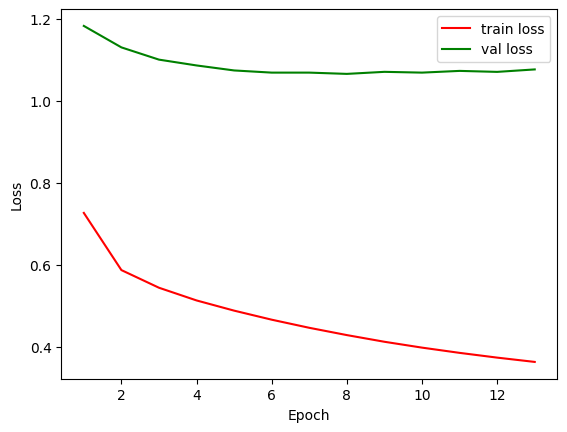

In [17]:
# Specify the folder where to save trained model
folder_model_name = 'trained_models/params_'+ str(n_params) +'M'

# Train the transformer and save best weights
trained_model_filt, _, _ = train(model=transformermodel,
                                train_loader=train_data_loader,
                                val_loader= val_data_loader,
                                epochs = 25,
                                lr = config['learning_rate'],
                                patience = 5,
                                target_tokenizer = tokenizers_n_data['target_tokenizer'],
                                device='cuda',
                                model_folder = folder_model_name)

# save config files (needed to reload trained models)
with open(folder_model_name+'/config.json', 'w') as file:
    json.dump(config, file )

# Translate the validation set

In [20]:
# Specify the folder with model and config dictionary to load
folder_model = 'trained_models/params_256M'

# Load config file 
with open(folder_model+'/config.json', 'r') as file:
    config = json.load( file )

# Tokenize the same data with same params. TODO save the tokenizer
tokenizers_n_data = create_tokenizer_and_corpus_train_test(lang1 = 'en', 
                                                           lang2 = 'it', 
                                                           train_split= config['train_split'], 
                                                           filter_range = config['filter_range'], 
                                                           method = config['method'])

# Hyperparams
source_vocab_size = tokenizers_n_data['source_tokenizer'].get_vocab_size()
target_vocab_size = tokenizers_n_data['target_tokenizer'].get_vocab_size()
source_pad_index, target_pad_index = tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]') , tokenizers_n_data['source_tokenizer'].token_to_id('[PAD]')

val_data = TranslationDataset(source_tokenizer = tokenizers_n_data['source_tokenizer'],
                                target_tokenizer =  tokenizers_n_data['target_tokenizer'],
                                source_corpus= tokenizers_n_data['source_val_set'],
                                target_corpus= tokenizers_n_data['target_val_set'],
                                source_seq_length = config['max_length'] ,
                                target_seq_length = config['max_length'] )

val_data_loader = DataLoader(val_data , batch_size = 10 ,shuffle= False)

Started with 32332 rows. 31303 rows are left


In [21]:
# Instantiate the transformer model and load weights
trained_model  = Transformer(target_vocab_size = target_vocab_size, 
                                source_vocab_size = source_vocab_size ,
                                target_pad_index = target_pad_index,
                                source_pad_index = source_pad_index,
                                embed_size = config['embed_size'], 
                                num_layers = config['num_layers'],
                                heads =  config['heads'],
                                device = config['device'],
                                expansion = config['expansion'],
                                dropout =  config['dropout'],
                                max_sentence_length = config['max_length'])

# load weights
state_dict = torch.load(folder_model + '/' + [i for i in os.listdir(folder_model) if '.pth' in i][0])
trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [22]:
# Function to perfom translation
def translate(model, 
              tokenizers_source, 
              tokenizers_target, 
              device , 
              source_text,
              expected_translation,
              sequence_length: int):
    """
    Translates a given source text using a trained sequence-to-sequence model.

    This function tokenizes the input text, processes it through the encoder-decoder 
    model, and generates a translation by iteratively predicting the next token 
    until the end-of-sequence token ([EOS]) is encountered.

    Args:
        model (torch.nn.Module): The trained sequence-to-sequence model.
        tokenizers_source (Tokenizer): Tokenizer for the source language.
        tokenizers_target (Tokenizer): Tokenizer for the target language.
        device (torch.device): The device (CPU/GPU) on which the model runs.
        source_text (list of str): List of sentences in the source language to be translated.
        expected_translation (list of str): Ground truth translations for comparison.
        sequence_length (int): The maximum sequence length for input/output.
    """


    model.eval()
    sos_tok= tokenizers_source.token_to_id('[SOS]')
    eos_tok  = tokenizers_source.token_to_id('[EOS]')
    pad_tok = tokenizers_source.token_to_id('[PAD]')

    for (sentence, groundtruth) in zip(source_text, expected_translation):
        ids = tokenizers_source.encode(sentence).ids
        # print(ids)
        padding_enc = sequence_length - len(ids) - 2 
        padding_dec = sequence_length -  1 
        encoder_input = torch.cat([
                        torch.tensor([sos_tok], dtype= torch.int64),
                        torch.tensor(ids, dtype= torch.int64),
                        torch.tensor([eos_tok], dtype= torch.int64),
                        torch.tensor([pad_tok]* padding_enc, dtype= torch.int64)]).unsqueeze(0)
    
        #print(encoder_input.shape)

        decoder_input = torch.cat([torch.tensor([sos_tok], dtype= torch.int64),
                                     torch.tensor([pad_tok] * padding_dec, dtype= torch.int64)]).unsqueeze(0)
        
        #print(decoder_input.shape)
        # print(decoder_input)
        model = model.to(device)
        encoder_input = encoder_input.to(device)
        decoder_input = decoder_input.to(device)
        translation  = torch.zeros(1,  sequence_length)
        next_token_index = 0
        new_token = None
        while new_token != eos_tok:
            output = model(encoder_input, decoder_input)
            # print(output.shape)
            sliceoutput = output[:,next_token_index,:]
            # print(sliceoutput.shape)
            new_token = torch.argmax(sliceoutput)
            # print(new_token)
            #print(new_token)
            decoder_input[0, next_token_index+1] = new_token.item()
            #print(decoder_input)
            translation[0, next_token_index  ] = new_token
            #print(translation)
            next_token_index += 1

        #print(translation)
        print('-'*30)
        translation = tokenizers_target.decode(translation.detach().cpu().numpy().astype('int')[0])
        print('Original sentence:', sentence)
        print("Translation:", translation)
        print('Expected translation:', groundtruth)


In [23]:
# Let's translate some random validation datapoints
translate(model = trained_model, 
            tokenizers_source = tokenizers_n_data['source_tokenizer'], 
            tokenizers_target = tokenizers_n_data['target_tokenizer'], 
            device='cuda',
            source_text = tokenizers_n_data['source_val_set'][30:50],
            expected_translation = tokenizers_n_data['target_val_set'][30:50],
            sequence_length = config['max_length'])

------------------------------
Original sentence: I can imagine how dreadful our Petersburg must appear to you after your delightful journey; I can picture to myself your honeymoon in Rome.
Translation: Io posso descrivere come la nostra Pietroburgo , quando vi tocchi fare , e vi posso essere disturbata in modo particolare .
Expected translation: Immagino come vi sembri orribile la nostra Pietroburgo dopo il vostro delizioso viaggio; immagino la vostra luna di miele a Roma.
------------------------------
Original sentence: "Yes, plainly: I often hear her: she sews in one of these rooms.
Translation: — Sì , sono orgoglioso , sono stata adatta , — ella mormorò .
Expected translation: — Sì, e la sento spesso. Ella cuce in una di queste stanze.
------------------------------
Original sentence: "Ain't you going to put the boots in?" said Harris.
Translation: — Non vi dispiace ? — disse Harris , — che vi ?
Expected translation: — E gli stivali dove li lasci? — disse Harris.
-----------------